# Test custom visualizer

In [1]:
import tensorflow as tf
import pandas as pd
import importlib
import  numpy as np

# Set seed
tf.random.set_seed(42)

import custom_visualizer

## Load data

In [2]:
# Load dataloader
DATASET_PATH = "../processed_data/transformer_dataset"  # adjust if needed

ds = (tf.data.Dataset
      .load(DATASET_PATH)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

In [3]:
# def extract_subset_from_dataloader(ds, k, split_id_filter=None, gameId=None, playId=None, frameId=None):
#     """
#     Extract up to `k` examples from the dataset `ds` that match the given filters,
#     supporting batch sizes > 1.

#     Args:
#         ds (tf.data.Dataset): The dataset yielding (ids, X, y) tuples.
#         split_id_filter (int): 0 for train, 1 for val, 2 for test.
#         k (int): Number of items to retrieve (or all if less than k available).
#         gameId (int, optional): Filter by gameId (ids[0]).
#         playId (int, optional): Filter by playId (ids[1]).
#         frameId (int, optional): Filter by frameId (ids[3]).

#     Returns:
#         List of tuples: [(ids, X, y), ...] with up to `k` items matching the filters.
#     """
#     result = []
#     for batch in ds:
#         ids_batch, X_batch, y_batch = batch  # shapes: (B, 4), (B, 100, 46), (B, 46)
#         for i in range(ids_batch.shape[0]):
#             ids = ids_batch[i]
#             if split_id_filter is not None and ids[2].numpy() != split_id_filter:
#                 continue
#             if gameId is not None and ids[0].numpy() != gameId:
#                 continue
#             if playId is not None and ids[1].numpy() != playId:
#                 continue
#             if frameId is not None and ids[3].numpy() != frameId:
#                 continue
#             result.append((
#                 tf.expand_dims(ids, axis=0),             # shape (1, 4)
#                 tf.expand_dims(X_batch[i], axis=0),      # shape (1, 100, 46)
#                 tf.expand_dims(y_batch[i], axis=0),      # shape (1, 46)
#             ))
#             if len(result) == k:
#                 return result
#     return result


In [4]:
# Extract all the sequences from the test set (takes about 3 min)
from custom_visualizer import extract_subset_from_dataloader
test_sequences = extract_subset_from_dataloader(ds, k=None, split_id_filter=2) # 2 for test set
print(f"Number of sequences for test set: {len(test_sequences)}")
print("First sequence:")
test_sequences[0]

Number of sequences for test set: 127908
First sequence:


2025-04-30 10:00:29.989905: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2022091900,        736,          2,          1]], dtype=int32)>,
 <tf.Tensor: shape=(1, 100, 46), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.74508333, 0.5502814 , 0.74583334, ..., 0.541651  ,
          0.712     , 0.55947465],
         [0.74441665, 0.54971856, 0.74408334, ..., 0.5420263 ,
          0.712     , 0.55947465]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
 array([[0.7435    , 0.5489681 , 0.742     , 0.56585366, 0.7564167 ,
         0.47673547, 0.7428333 , 0.5313321 , 0.75675   , 0.55572236,
         0.75275 

In [5]:
# Drop all sequences in which the first vector has all zeros
old_n = len(test_sequences)
test_sequences = [seq for seq in test_sequences if not np.all(seq[1].numpy()[0, 0] == 0)]
print(f"Number of sequences dropped: {old_n - len(test_sequences)}")
print(f"Number of sequences for test set after dropping all-zero sequences: {len(test_sequences)}")

Number of sequences dropped: 76766
Number of sequences for test set after dropping all-zero sequences: 51142


In [6]:
# Convert the sequences to a DataFrame
from custom_visualizer import covert_sequences_to_df
test_df = covert_sequences_to_df(test_sequences)

test_df.head()

,X,y,gameId,playId,frameId
0,"(((tf.Tensor(0.74508333, shape=(), dtype=float...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,1
1,"(((tf.Tensor(0.74441665, shape=(), dtype=float...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,2
2,"(((tf.Tensor(0.7435, shape=(), dtype=float32),...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,3
3,"(((tf.Tensor(0.7424167, shape=(), dtype=float3...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,4
4,"(((tf.Tensor(0.74125, shape=(), dtype=float32)...","((tf.Tensor(0.71683335, shape=(), dtype=float3...",2022091900,736,5


In [7]:
# Get all the gameIds from the test set
gameIds = test_df['gameId'].unique()
print(f"Number of unique gameIds in the test set: {len(gameIds)}")
print(f"Unique gameIds: {gameIds}")

Number of unique gameIds in the test set: 7
Unique gameIds: [2022091900 2022091812 2022091811 2022091807 2022090800 2022091803
 2022091109]


In [8]:
# Count the amount of frames per gameId and playId (transform)
test_df['frame_count'] = test_df.groupby(['gameId', 'playId'])['frameId'].transform('count')

# We have to add 100 to the frame count, because the last row has 100 frames in input plust the target
test_df['frame_count'] = test_df['frame_count'] + 100

# Value counts for count
print(test_df['frame_count'].value_counts())

test_df.head()

frame_count
178    936
195    855
185    850
170    840
204    832
      ... 
103      9
104      8
107      7
102      4
101      1
Name: count, Length: 156, dtype: int64


,X,y,gameId,playId,frameId,frame_count
0,"(((tf.Tensor(0.74508333, shape=(), dtype=float...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,1,194
1,"(((tf.Tensor(0.74441665, shape=(), dtype=float...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,2,194
2,"(((tf.Tensor(0.7435, shape=(), dtype=float32),...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,3,194
3,"(((tf.Tensor(0.7424167, shape=(), dtype=float3...","((tf.Tensor(0.71675, shape=(), dtype=float32),...",2022091900,736,4,194
4,"(((tf.Tensor(0.74125, shape=(), dtype=float32)...","((tf.Tensor(0.71683335, shape=(), dtype=float3...",2022091900,736,5,194


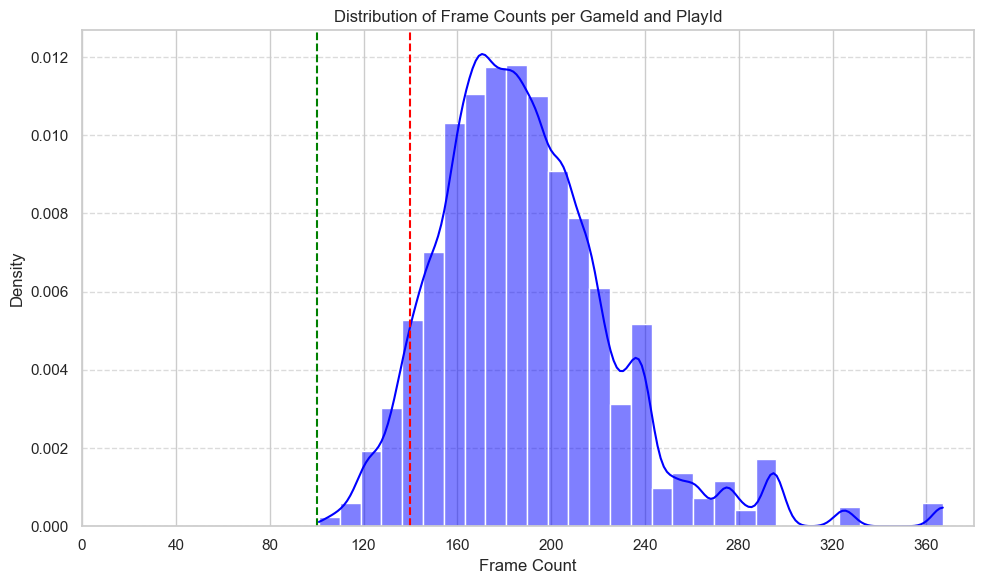

In [9]:
# Plot histogram of frame counts per gameId and playId
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a histogram of the frame counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df['frame_count'], bins=30, kde=True, color='blue', stat='density')
# Vertical line at 140
plt.axvline(x=140, color='red', linestyle='--', label='140 frames')
# Vertical line at 100
plt.axvline(x=100, color='green', linestyle='--', label='100 frames')
plt.title('Distribution of Frame Counts per GameId and PlayId')
plt.xlabel('Frame Count')
plt.ylabel('Density')
plt.xticks(ticks=range(0, test_df['frame_count'].max() + 1, 5))  # Set x-ticks to be integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure x-ticks are integers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Print the number of plays with at least 100 frames
print(f"Number of plays with at least 100 frames: {len(test_df[test_df['frame_count'] >= 100])}", "out of", len(test_df))
print(f"Number of plays with at least 140 frames: {len(test_df[test_df['frame_count'] >= 140])}", "out of", len(test_df))

Number of plays with at least 100 frames: 51142 out of 51142
Number of plays with at least 140 frames: 47825 out of 51142


In [11]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences)}")

play_sequences.head()

Selected playId: 4443
Number of sequences for playId 4443: 209


,X,y,gameId,playId,frameId,frame_count
32083,"(((tf.Tensor(0.39225, shape=(), dtype=float32)...","((tf.Tensor(0.43641666, shape=(), dtype=float3...",2022091109,4443,1,205
32084,"(((tf.Tensor(0.39316666, shape=(), dtype=float...","((tf.Tensor(0.43641666, shape=(), dtype=float3...",2022091109,4443,2,205
32085,"(((tf.Tensor(0.39408332, shape=(), dtype=float...","((tf.Tensor(0.43641666, shape=(), dtype=float3...",2022091109,4443,3,205
32086,"(((tf.Tensor(0.395, shape=(), dtype=float32), ...","((tf.Tensor(0.43641666, shape=(), dtype=float3...",2022091109,4443,4,205
32087,"(((tf.Tensor(0.39591667, shape=(), dtype=float...","((tf.Tensor(0.43633333, shape=(), dtype=float3...",2022091109,4443,5,205


## Testing

In [12]:
# Print the shape of one observation from train
# (try to get one of the last obsevations)
pct = 0.8
k = int(len(play_sequences) * pct)
print(f"Selected observation: {k}")

one_observation = play_sequences.iloc[k]

print("Shape of one observation from train set:", one_observation.shape)
print("Shape of the first column:", one_observation.iloc[0].shape)
print("Shape of the second column:", one_observation.iloc[1].shape)

# Look at the values from the columns
print("Values from the first column (ids):", one_observation.iloc[0].numpy())
print("Values from the second column (X):", one_observation.iloc[1].numpy())

Selected observation: 167
Shape of one observation from train set: (6,)
Shape of the first column: (1, 100, 46)
Shape of the second column: (1, 46)
Values from the first column (ids): [[[0.433      0.5555347  0.43583333 ... 0.2272045  0.44425002 0.55722326]
  [0.433      0.5553471  0.43575    ... 0.22551595 0.44425002 0.55722326]
  [0.433      0.5553471  0.43566668 ... 0.22420263 0.44425002 0.55722326]
  ...
  [0.37883332 0.54183865 0.49158335 ... 0.34502813 0.37866667 0.5337711 ]
  [0.37808332 0.5412758  0.493      ... 0.34409004 0.37725002 0.5345216 ]
  [0.37758332 0.54108816 0.49416667 ... 0.3435272  0.37608334 0.5354597 ]]]
Values from the second column (X): [[0.37716666 0.54071295 0.49508333 0.8600375  0.38908333 0.4834897
  0.37683332 0.5966229  0.44325    0.25928706 0.40983334 0.5682927
  0.5071667  0.5022514  0.4615     0.4988743  0.402      0.50769234
  0.39708334 0.61144465 0.404      0.5463415  0.39133334 0.46829268
  0.37858334 0.60712945 0.5926667  0.7530957  0.416      0.

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

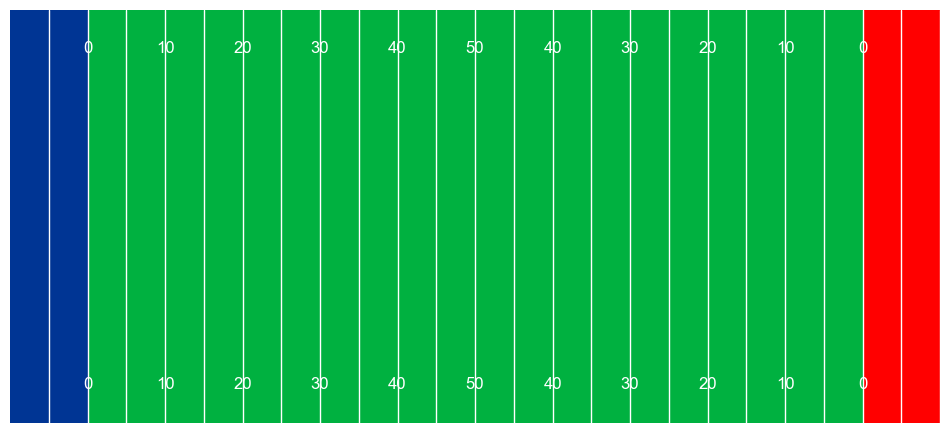

In [13]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

custom_visualizer.plot_pitch()

In [14]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to extract the trajectory of one player
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.43466666, 0.39530957],
       [0.43466666, 0.39530957],
       [0.43466666, 0.39530957],
       [0.43466666, 0.39530957],
       [0.43466666, 0.39530957],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39530957],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39493433],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39512196],
       [0.43466666, 0.39493433],
       [0.43475   , 0.39493433],
       [0.43475   , 0.39512196],
       [0.43475   , 0.39493433],
       [0.43475   , 0.39474672],
       [0.43475   , 0.39474672],
       [0.43483335, 0.39474672],
       [0.43483335, 0.39493433],
       [0.43483335, 0.39474672],
       [0.43483335, 0.39474672],
       [0.43483335, 0.39474672],
       [0.43483335, 0.39474672],
       [0.43491668, 0.39474672],
       [0.43491668, 0.39474672],
       [0.43491668, 0.3947

In [15]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test descaling function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj = custom_visualizer.descale_trajectory(traj)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[52.16    , 21.07    ],
       [52.16    , 21.07    ],
       [52.16    , 21.07    ],
       [52.16    , 21.07    ],
       [52.16    , 21.07    ],
       [52.16    , 21.06    ],
       [52.16    , 21.07    ],
       [52.16    , 21.06    ],
       [52.16    , 21.06    ],
       [52.16    , 21.05    ],
       [52.16    , 21.06    ],
       [52.16    , 21.06    ],
       [52.16    , 21.06    ],
       [52.16    , 21.06    ],
       [52.16    , 21.05    ],
       [52.17    , 21.05    ],
       [52.17    , 21.06    ],
       [52.17    , 21.05    ],
       [52.17    , 21.039999],
       [52.17    , 21.039999],
       [52.18    , 21.039999],
       [52.18    , 21.05    ],
       [52.18    , 21.039999],
       [52.18    , 21.039999],
       [52.18    , 21.039999],
       [52.18    , 21.039999],
       [52.190002, 21.039999],
       [52.190002, 21.039999],
       [52.190002, 21.039999],
       [52.190002, 21.039999],
       [52.190002, 2

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

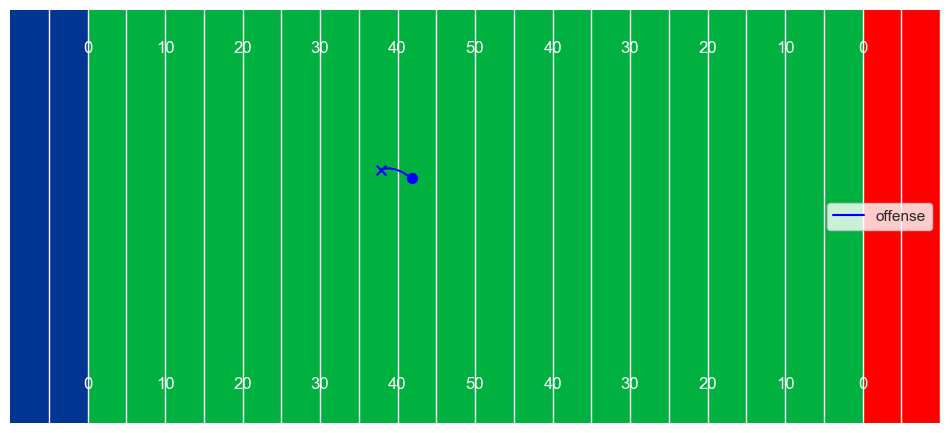

In [16]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='offense')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

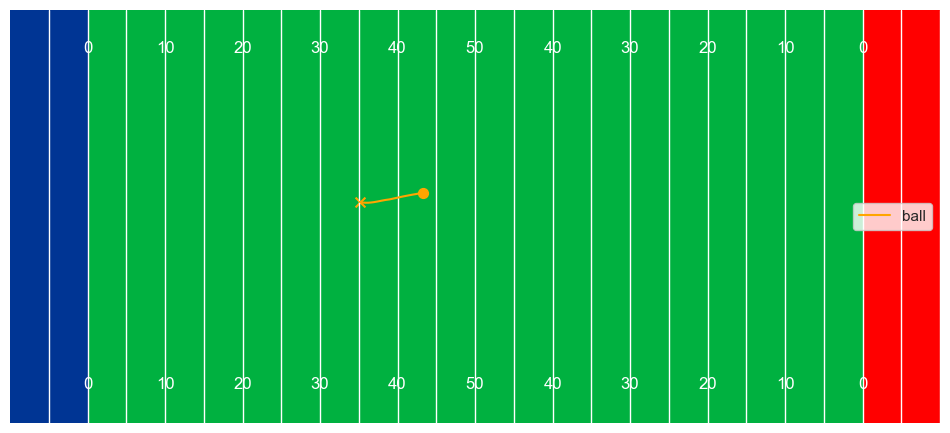

In [17]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, team='ball', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='ball')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

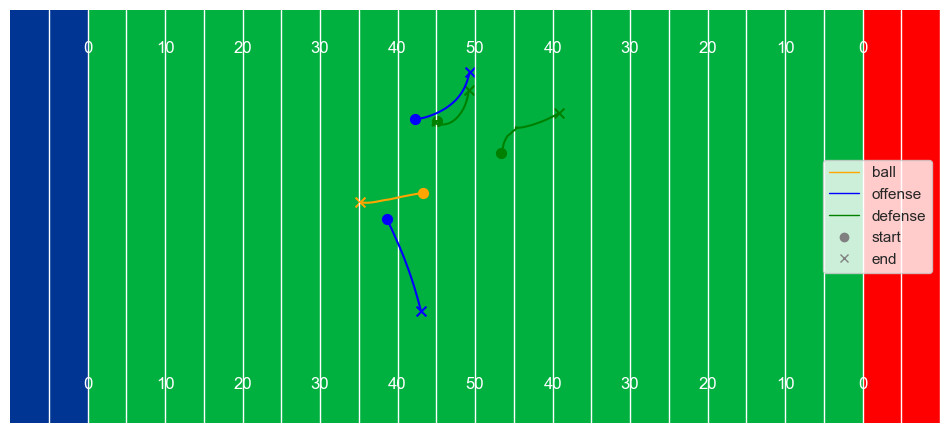

In [18]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense=[1,4], defense=[2,5], include_ball=True)

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

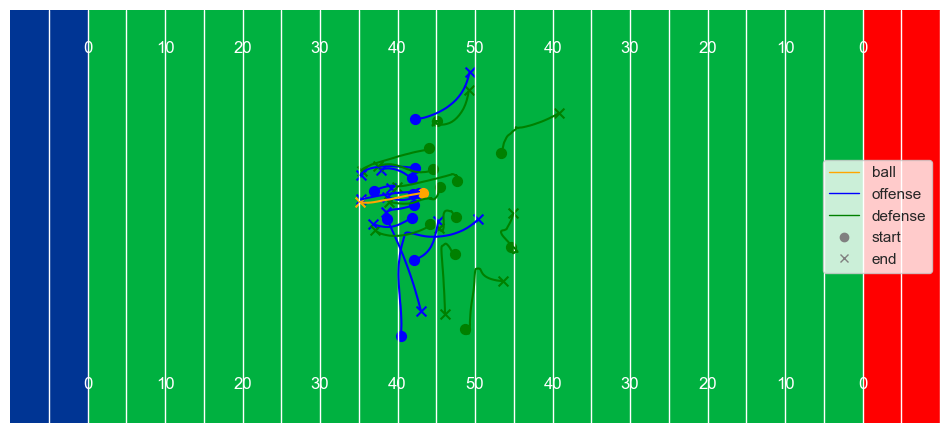

In [19]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense='all', defense='all', include_ball=True)

## Now full trajectories
Now let's try making a differnce between input, ground truth and predicted

In [20]:
from custom_visualizer import extract_full_sequence

In [21]:
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

(1, 309, 46)


(1, 309, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

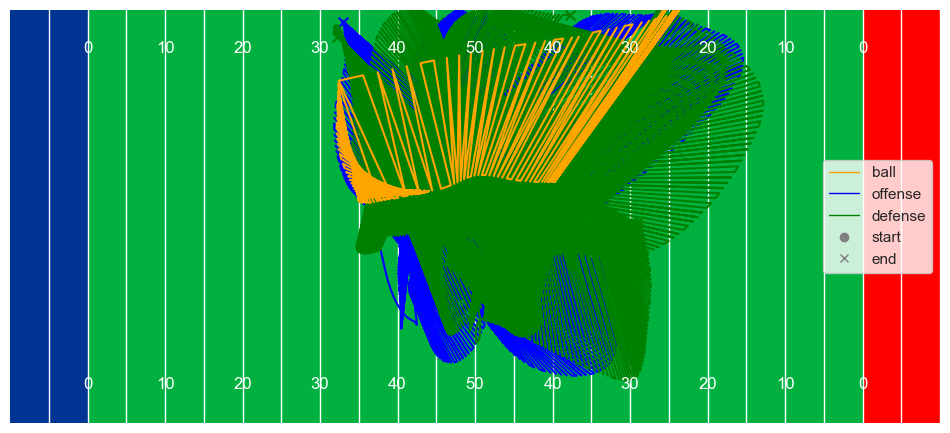

In [22]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)


Selected playId: 1991
Number of sequences for playId 1991: 156
(1, 256, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

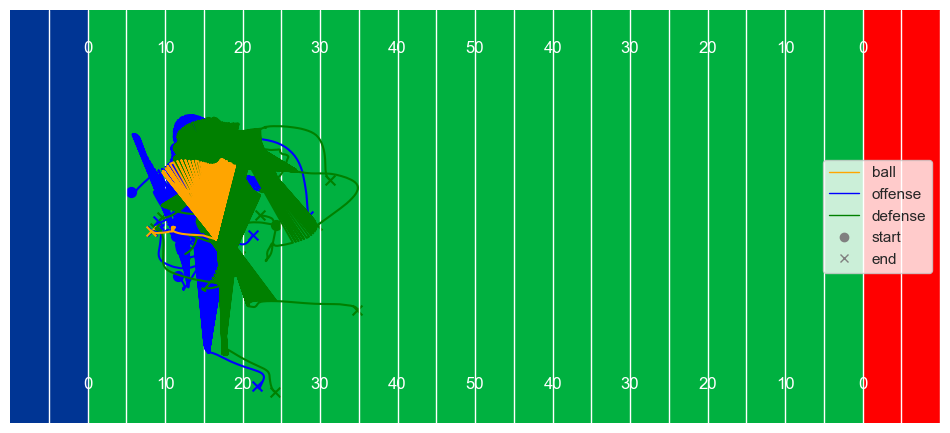

In [23]:
# Try a different play

# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)

Selected playId: 2541
Number of sequences for playId 2541: 85
(1, 185, 46)
(1, 85, 46)
First 2 values of first_X: tf.Tensor(
[[0.57475    0.53958726]
 [0.574      0.5393996 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.61125   0.5766417]
 [0.61125   0.5766417]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

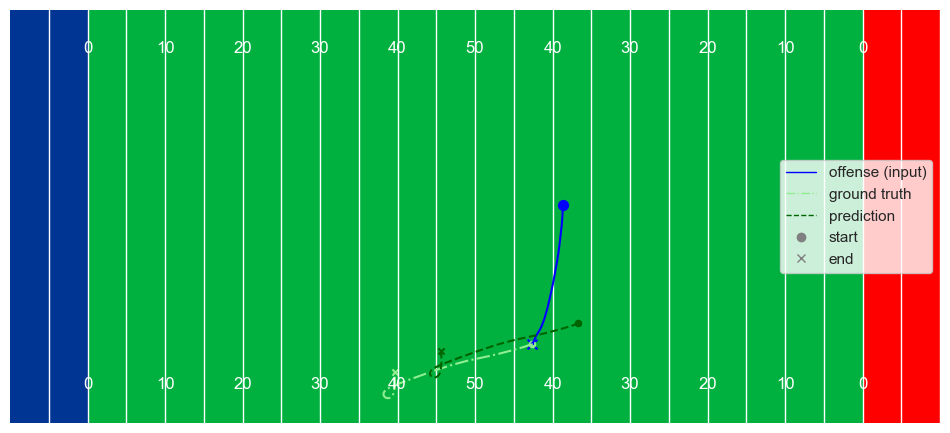

In [24]:
# Select the frames from one random playId with at least 140 frames
playId = 2541
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 1657
Number of sequences for playId 1657: 139
(1, 239, 46)
(1, 139, 46)
First 2 values of first_X: tf.Tensor(
[[0.505     0.5290807]
 [0.5050833 0.5294559]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.8415     0.5378049 ]
 [0.55233335 0.60572237]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

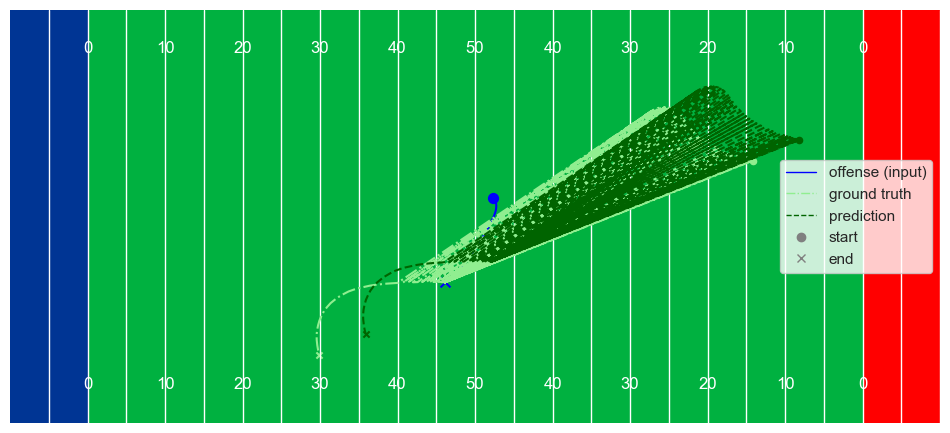

In [25]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 1817
Number of sequences for playId 1817: 77
(1, 177, 46)
First 2 values of first_X: tf.Tensor(
[[0.53533334 0.5360225 ]
 [0.53533334 0.5360225 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.55829126 0.55548054]
 [0.5565764  0.5497651 ]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

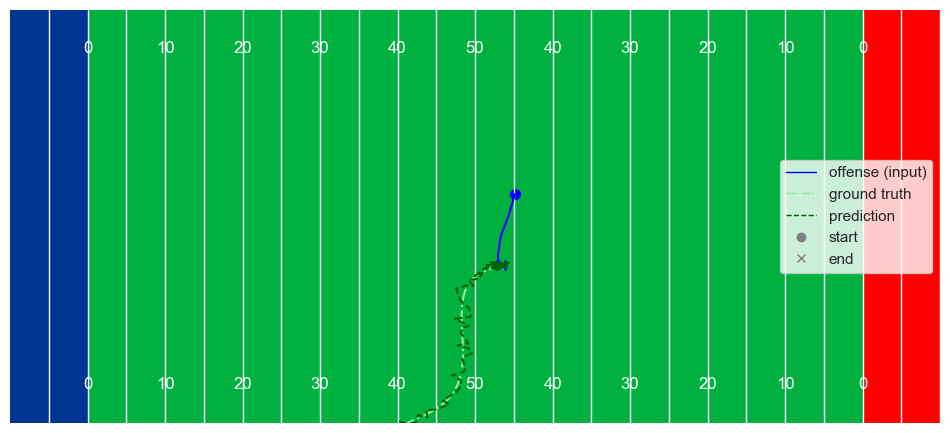

In [26]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Add very small random noise around zero
noise_scale = 0.01  # much smaller noise
noise = tf.random.uniform(subsequent_X.shape, minval=-noise_scale, maxval=noise_scale)

# Simulated prediction: ground truth + small noise
pred = subsequent_X + noise

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[1],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Predicted sequence shape: (1, 77, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

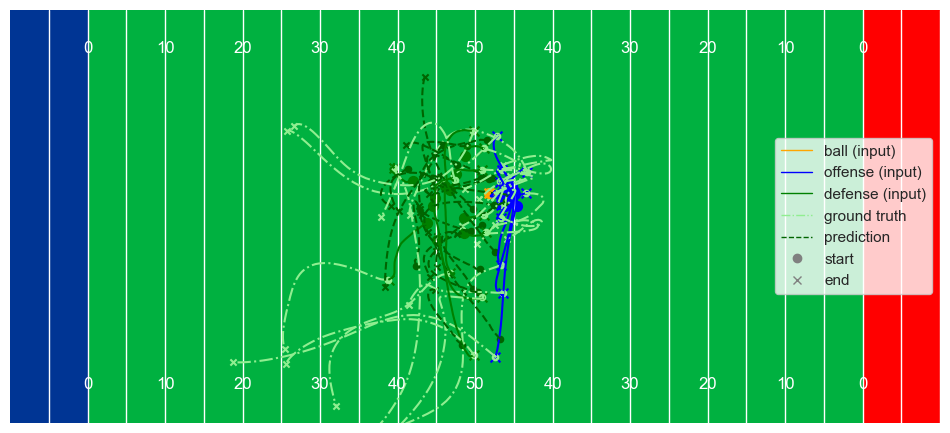

In [29]:
# ╔════════════════════════════════════════╗
# ║ 24. Load model, predict & visualize   ║
# ╚════════════════════════════════════════╝


import tensorflow as tf
import numpy as np
import custom_visualizer

# ── 1) Rolling‐window prediction helper ────────────────────────────────────────
def predict_future_sequence(model, seed_seq, horizon=40):
    """
    Roll a one‐step LSTM forward to predict `horizon` frames.
    seed_seq: (1, window_len, feature_dim) array or tensor
    Returns: (1, horizon, feature_dim) NumPy array
    """
    # ensure NumPy array
    seq = seed_seq.numpy() if isinstance(seed_seq, tf.Tensor) else seed_seq.copy()
    preds = []
    for _ in range(horizon):
        # predict one step
        yhat = model.predict(seq, verbose=0)        # (1, feature_dim)
        preds.append(yhat[0])                       # store (feature_dim,)
        # slide window: drop first, append prediction
        new_frame = yhat.reshape((1, 1, -1))        # (1,1,feature_dim)
        seq = np.concatenate([seq[:,1:,:], new_frame], axis=1)
    # stack into (1, horizon, feature_dim)
    return np.expand_dims(np.stack(preds, axis=0), axis=0)

# ── 2) Load trained model for inference ───────────────────────────────────────
model = tf.keras.models.load_model(
    "saved_models/lstm_position_only_best.keras",
    compile=False
)

# ── 3) Predict future frames for our selected play ────────────────────────────
# (first_X and subsequent_X were defined in the previous cell)
horizon = subsequent_X.shape[1]      # e.g. 40
pred_seq = predict_future_sequence(model, first_X, horizon=horizon)
print(f"Predicted sequence shape: {pred_seq.shape}")

# ── 4) Visualize past, ground truth & prediction ─────────────────────────────
custom_visualizer.plot_trajectories(
    sequence=first_X,                # known history
    ground_truth_seq=subsequent_X,   # true future frames
    pred_seq=pred_seq,               # predicted future frames
    offense='all',
    defense='all',
    include_ball=True
)


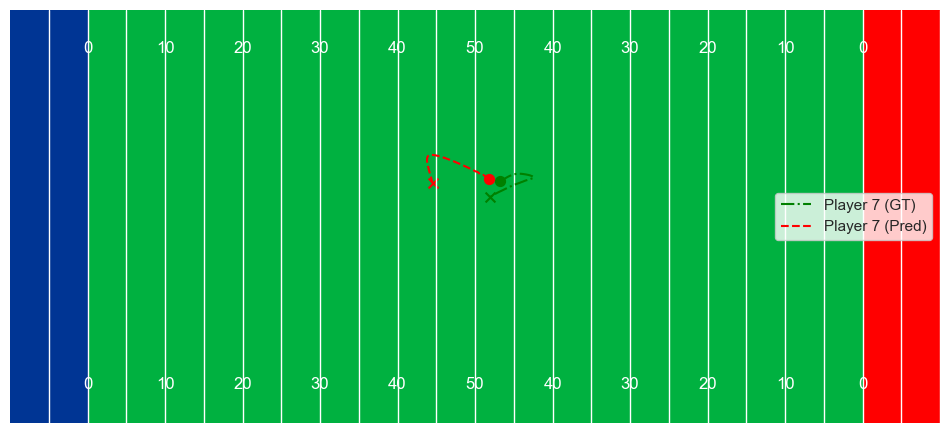

In [34]:
# ╔════════════════════════════════════════════╗
# ║ 25. Slice & Plot Single Player Trajectory ║
# ╚════════════════════════════════════════════╝

import matplotlib.pyplot as plt

# 1️⃣ Select which player (0–22) to visualize
player_idx = 7  # change this to any player index

# 2️⃣ Slice out that player’s (x,y) from ground truth and prediction
#    subsequent_X: true future frames tensor, shape (1, T, 46)
#    pred_seq:      predicted future frames array, shape (1, T, 46)
gt_player = subsequent_X[:, :, 2*player_idx : 2*player_idx + 2]  # shape (1, T, 2)
pred_player = pred_seq   [:, :, 2*player_idx : 2*player_idx + 2]

# 3️⃣ Descale back to field coordinates (yards)
gt_coords   = custom_visualizer.descale_trajectory(gt_player[0])
pred_coords = custom_visualizer.descale_trajectory(pred_player[0])

# 4️⃣ Plot pitch and overlay trajectories
fig, ax = custom_visualizer.plot_pitch()

# Ground-truth trajectory
custom_visualizer.plot_player_trajectory(
    gt_coords,
    ax=ax,
    traj_label=f"Player {player_idx} (GT)",
    traj_color="green",
    linestyle="-.",
    show_markers=True
)

# Predicted trajectory
custom_visualizer.plot_player_trajectory(
    pred_coords,
    ax=ax,
    traj_label=f"Player {player_idx} (Pred)",
    traj_color="red",
    linestyle="--",
    show_markers=True
)

plt.show()


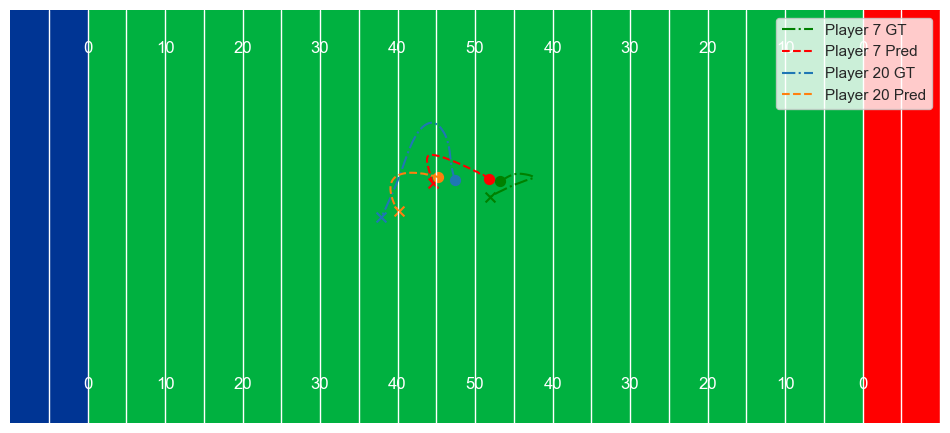

In [40]:
# ╔════════════════════════════════════════════════════╗
# ║ 26. Slice & Plot Multiple Player Trajectories    ║
# ╚════════════════════════════════════════════════════╝

import matplotlib.pyplot as plt

# 1️⃣ Specify which players to visualize (0–22)
player_indices = [7, 20]  # change these as needed

# 2️⃣ Define contrasting color pairs for each player: (GT_color, Pred_color)
color_pairs = [
    ("green", "red"),      # for player 1
    ("tab:blue", "tab:orange"),  # for player 7
    ("purple", "magenta")  # for player 8
]

# 3️⃣ Draw the pitch once
fig, ax = custom_visualizer.plot_pitch()

# 4️⃣ Loop over each player, slice their coords, descale, and plot
for (player_idx, (gt_color, pred_color)) in zip(player_indices, color_pairs):
    # slice out that player's x,y from true future and prediction
    gt_player   = subsequent_X [:, :, 2*player_idx : 2*player_idx + 2]  # (1, T, 2)
    pred_player = pred_seq     [:, :, 2*player_idx : 2*player_idx + 2]

    # descale to real field units
    gt_coords   = custom_visualizer.descale_trajectory(gt_player[0])
    pred_coords = custom_visualizer.descale_trajectory(pred_player[0])

    # ground-truth path (dash-dot), with start/end markers
    custom_visualizer.plot_player_trajectory(
        gt_coords,
        ax=ax,
        traj_label=f"Player {player_idx} GT",
        traj_color=gt_color,
        linestyle='-.',
        show_markers=True,
        marker_size=50
    )

    # predicted path (dashed), with start/end markers
    custom_visualizer.plot_player_trajectory(
        pred_coords,
        ax=ax,
        traj_label=f"Player {player_idx} Pred",
        traj_color=pred_color,
        linestyle='--',
        show_markers=True,
        marker_size=50
    )

# 5️⃣ Finalize and show legend
plt.legend(loc='upper right')
plt.show()
